# Importing Libraries

In [2]:
import os, shutil
from tqdm import tqdm_notebook as tqdm
import tensorflow as tf
import keras as k
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
from sklearn.utils import shuffle
import os, argparse, random, pickle, cv2, fnmatch
from os.path import join

%matplotlib inline
print('Using Keras version: {}, and Tensorflow version: {}'.format(k.__version__, tf.__version__))


Using Keras version: 2.1.5, and Tensorflow version: 1.13.1


# Labels
## Create a list of labels

In [41]:
images = []
sequences = []
image_sequences = []
pspi_scores = []


#extracting the images name and PSPI Score
for subject_id in os.listdir('Images'):
    if subject_id != '.DS_Store':
        for sequence_id in os.listdir(join('Images', subject_id)):
            if sequence_id != '.DS_Store':
                sequences.append(sequence_id)
                for image in os.listdir(join('Images', subject_id, sequence_id)):
                    if image != '.DS_Store':
                        images.append(image.split('.')[0])
                        image_sequences.append(sequence_id)
                for pspi_file in os.listdir(join('Frame_Labels', 'PSPI', subject_id, sequence_id)):
                    with open(join('Frame_Labels', 'PSPI', subject_id, sequence_id, pspi_file), 'r') as f_in:
                        pspi_scores.append(float(f_in.read().strip()))
                        
#Creating Table for images and PSPI                        
labels_data = {'image': images,
              'pspi_score': pspi_scores}

labels_df = pd.DataFrame(data=labels_data)

#Checking Output format and content
print(labels_df.describe())
print('\n[INFO] TABLE EXAMPLE CAPTURED BELOW')
labels_df[:1]


         pspi_score
count  48398.000000
mean       0.446981
std        1.302021
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       15.000000

[INFO] TABLE EXAMPLE CAPTURED BELOW


,image,pspi_score
0,fn059t2afunaff048,0.0


# Images
## Create a list of the paths of the files that contain the Images

In [42]:
images_path = []
def find_files(directory, pattern):
    for root, dirs, files in os.walk(directory):
        for basename in files:
            if fnmatch.fnmatch(basename, pattern):
                filename = os.path.join(root, basename)
                yield filename


for filename in find_files('/data/home/maj/notebooks/w210-final-project/MAJ/Images', '*.png'):
    images_path.append(filename)

images_path_df = pd.DataFrame(data=images_path)

print("images_path shape:", images_path_df.shape)

#extracting the .png file name from the first dataset and joining with the image & PSPI score dataset
images_path_df

#renaming dataframe column to image path
images_path_df.columns = ['image_path']

# new temp data frame with split value columns 
temp = images_path_df["image_path"].str.split("/", n = 10, expand = True) 
temp.columns = ['zero','one','two','three','four','five','six','seven', 'eight','nine', 'ten']

# Create new temp dataframe that has image name without .png to later do a merge
temp2 = temp["ten"].str.split(".", n = 1, expand = True) 
temp2.columns = ['image','ext']
temp2.drop(columns =["ext"], inplace = True) 

images_df = pd.concat([images_path_df, temp2], axis =1)
print('\n[INFO] SAMPLE FROM DATASET CAPTURED BELOW')
images_df[:1]


images_path shape: (48398, 1)

[INFO] SAMPLE FROM DATASET CAPTURED BELOW


,image_path,image
0,/data/home/maj/notebooks/w210-final-project/MA...,fn059t2afunaff048


# Merging
## Creating table with Image Path, Image Name and PSPI Score

In [43]:
#doing a merge on the .png value to ensure that the path will match the PSPI value
merged_inner = pd.merge(left=labels_df,right=images_df, left_on='image', right_on='image')
print('merged table: ', merged_inner.shape)

#reordering columns
merged_inner= merged_inner [['image_path', 'image', 'pspi_score']]

#Final Dataset for pain dataset to by used in CNN
pain_data = merged_inner


print('\n[INFO] Final Dataset ready for CNN')


print('\n[INFO] MERGED TABLE EXAMPLE CAPTURED BELOW')
pain_data[:1]


merged table:  (48398, 3)

[INFO] Final Dataset ready for CNN

[INFO] MERGED TABLE EXAMPLE CAPTURED BELOW


,image_path,image,pspi_score
0,/data/home/maj/notebooks/w210-final-project/MA...,fn059t2afunaff048,0.0


In [44]:
# examine unique PSPI values
folder_list = pain_data['pspi_score'].unique()
folder_list

array([ 0.,  2.,  1.,  6.,  4., 11.,  3.,  5., 10.,  7.,  8.,  9., 12.,
       13., 14., 15.])

In [45]:
# example image filename
pain_data.loc[0]['image_path'].split('/')[-1]

'fn059t2afunaff048.png'

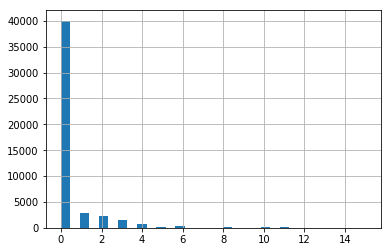

In [46]:
#Histogram for PSPI Score
hist = pain_data['pspi_score'].hist(bins=32)
hist

In [47]:
#Value Percentage distribution
pain_data['pspi_score'].value_counts().sort_index() / len(pain_data)

0.0     0.827080
1.0     0.060106
2.0     0.048576
3.0     0.029175
4.0     0.016571
5.0     0.005000
6.0     0.005579
7.0     0.001095
8.0     0.001632
9.0     0.000661
10.0    0.001384
11.0    0.001570
12.0    0.000992
13.0    0.000455
14.0    0.000021
15.0    0.000103
Name: pspi_score, dtype: float64

In [49]:
#Value Count
pain_data['pspi_score'].value_counts().sort_index()

0.0     40029
1.0      2909
2.0      2351
3.0      1412
4.0       802
5.0       242
6.0       270
7.0        53
8.0        79
9.0        32
10.0       67
11.0       76
12.0       48
13.0       22
14.0        1
15.0        5
Name: pspi_score, dtype: int64

In [50]:
# PSPI Score Description
pain_data['pspi_score'].describe()

count    48398.000000
mean         0.446981
std          1.302021
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         15.000000
Name: pspi_score, dtype: float64

In [51]:
# Pre-process images for visualization
# initialize the data and labels
image_list = [] 
pic_path = []

label_list = pain_data['pspi_score'].tolist() 

# loop over the input images
print("[INFO] loading images...")

imagePaths = list(pain_data['image_path'])

for imagePath in imagePaths[:25]:
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (320, 240)) # resize
    image_list.append(image)
    pic_path.append(imagePath)

[INFO] loading images...


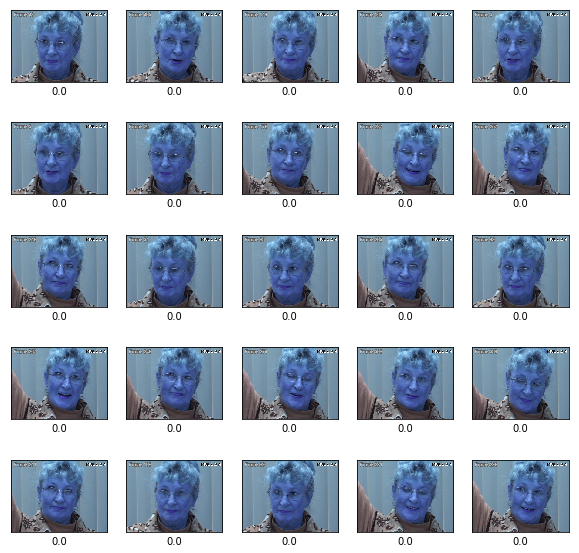

In [52]:
# Visualize some of the images in the dataset

plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image_list[i], cmap=plt.cm.binary)
    plt.xlabel(label_list[i])
plt.show()

In [56]:
# Adding pain/no pain classification
pain_data['pain'] = np.where(pain_data['pspi_score'] > 0, 'Pain', 'No Pain')

In [57]:
pain_data.columns

Index(['image_path', 'image', 'pspi_score', 'pain'], dtype='object')

In [59]:
print(pain_data['pain'].describe())

pain_data.head()

count       48398
unique          2
top       No Pain
freq        40029
Name: pain, dtype: object


,image_path,image,pspi_score,pain
0,/data/home/maj/notebooks/w210-final-project/MA...,fn059t2afunaff048,0.0,No Pain
1,/data/home/maj/notebooks/w210-final-project/MA...,fn059t2afunaff405,0.0,No Pain
2,/data/home/maj/notebooks/w210-final-project/MA...,fn059t2afunaff119,0.0,No Pain
3,/data/home/maj/notebooks/w210-final-project/MA...,fn059t2afunaff163,0.0,No Pain
4,/data/home/maj/notebooks/w210-final-project/MA...,fn059t2afunaff003,0.0,No Pain


In [36]:
# Shuffle Dataset
random.seed(42)
pain_data = shuffle(pain_data)

pain_data.reset_index(inplace = True)

counter = 0
for row in range(len(pain_data)):
    if pain_data['pain'][row] == 'No Pain':
        pain_data.loc[row, 'pain'] = 'NoPain'
        counter = counter +1
        print(row,end='\r')
        if counter > 8369:
            print('Dropping...')
            pain_data.drop(pain_data.loc[pain_data['pain']=='No Pain'].index, inplace=True)
            break


/anaconda/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Dropping...


/anaconda/envs/py36/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [38]:
len(pain_data[pain_data['pain']=='NoPain']), len(pain_data[pain_data['pain']=='Pain'])

(8370, 8369)

# Load & Save to Disk

In [15]:
# initialize the data and labels
image_list = [] 

label_list = pain_data['pspi_score'].tolist() 

# loop over the input images
print("[INFO] loading images...")

imagePath = pain_data['image_path']

for imagePth in imagePath:
    image = cv2.imread(imagePth)
    image = cv2.resize(image, (320, 240)) # resize
    image_list.append(image)

    
print("[INFO] Pictures loaded")

final_Array = np.array(image_list)
final_Labels = np.array(label_list)


print('[INFO] Array of data: {}, array of labels: {}'.format(final_Array.shape, final_Labels.shape))
print('[INFO] Saving ...')
np.save('Images_Data', final_Array)
np.save('Images_Labels', final_Labels)
np.save('Image_Path', imagePath)
print('[INFO] Datasets Saved')

[INFO] loading images...
[INFO] Pictures loaded
[INFO] Array of data: (16739, 240, 320, 3), array of labels: (16739,)
[INFO] Saving ...
[INFO] Datasets Saved
